### Importing Libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from kerastuner import GridSearch
import matplotlib.pyplot as plot
from keras.utils import np_utils
import pandas as pd

from IPython.display import display
import time

C:\Users\surya\AppData\Local\Temp\ipykernel_37312\3356068099.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import GridSearch


# Grid Search using SGD Optimiser

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

n=30000
x_train = x_train[1:n]
y_train=y_train[1:n]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [3]:
def create_Grid_Search_SGD_model(parameters):
    
    selectedLearningRate = parameters.Choice('learning_rate',values=[0.001,0.01,0.1])
    selectedBatchSize = parameters.Choice('batch_size',values= [32,64,128])
    
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = SGD(learning_rate = selectedLearningRate)
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [4]:
gridSearch_SGD_optimiser = GridSearch(
                        create_Grid_Search_SGD_model,
                        objective = 'val_loss',
                        seed = 42,
                        directory = 'GridSearch_SGD',
                        project_name = 'mnist_data'
                    )


In [5]:
start_time = time.time()
gridSearch_SGD_optimiser.search(x_train, y_train, validation_data = (x_validation, y_validation), epochs = 10)
end_time = time.time()
print(f'\n\nTotal time to execute Grid Search(SGD) is : {end_time - start_time} seconds')

Trial 9 Complete [00h 00m 42s]
val_loss: 0.046631816774606705

Best val_loss So Far: 0.046631816774606705
Total elapsed time: 00h 06m 20s
INFO:tensorflow:Oracle triggered exit


Total time to execute Grid Search(SGD) is : 379.8973112106323 seconds


In [6]:
gridSearch_SGD_param_values = gridSearch_SGD_optimiser.oracle.trials.values()

trainingLoss_data = []
validationLoss_data = []
bestTrainingLoss_data = []
bestValidationLoss_data = []

currentBestTrainingLoss = currentBestValidationLoss = float("inf")


parameters = []
counter = 1

for parameter in gridSearch_SGD_param_values:
    trainingLoss = parameter.metrics.get_history('loss')[-1].value[0]
    validationLoss = parameter.metrics.get_history('val_loss')[-1].value[0]
    trainingAccuracy = parameter.metrics.get_history('accuracy')[-1].value[0]
    validationAccuracy = parameter.metrics.get_history('val_accuracy')[-1].value[0]
    trainingLoss_data.append(trainingLoss)
    validationLoss_data.append(validationLoss)
    
    parameter_dictionary = {
        "Trial": counter,
        "Learning Rate": parameter.hyperparameters.get("learning_rate"),
        "Batch Size": parameter.hyperparameters.get("batch_size"),
        "Training Accuracy": trainingAccuracy,
        "Validation Accuracy": validationAccuracy,
        "Training Loss": trainingLoss,
        "Validation Loss": validationLoss
    }
    
    if validationLoss < currentBestValidationLoss:
        currentBestValidationLoss = validationLoss
    
    if trainingLoss < currentBestTrainingLoss:
        currentBestTrainingLoss = trainingLoss
    
    bestTrainingLoss_data.append(currentBestTrainingLoss)
    bestValidationLoss_data.append(currentBestValidationLoss)
    
    parameters.append(parameter_dictionary)
    counter += 1

gridSearch_SGD_Parameters_df = pd.DataFrame(parameters)


In [7]:
display(gridSearch_SGD_Parameters_df)

,Trial,Learning Rate,Batch Size,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.001,32,0.853452,0.901833,0.475199,0.357356
1,2,0.001,64,0.854536,0.902500,0.484715,0.366013
2,3,0.001,128,0.861536,0.906500,0.456551,0.346828
3,4,0.010,32,0.961748,0.968333,0.126196,0.102437
4,5,0.010,64,0.961832,0.969500,0.122659,0.102251
5,6,0.010,128,0.961665,0.969167,0.124166,0.102783
6,7,0.100,32,0.982958,0.984833,0.052765,0.050141
7,8,0.100,64,0.981666,0.983500,0.055077,0.050415
8,9,0.100,128,0.983083,0.985500,0.050329,0.046632


In [13]:
testLoss_data = []
bestTestLoss_data = []
currentBestTestLoss = float("inf")
optimisedParameters = {}

counter = 1

for parameter in gridSearch_SGD_param_values:
    
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = SGD(learning_rate = parameter.hyperparameters.get('learning_rate'))
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size = parameter.hyperparameters.get('batch_size'), epochs = 10)
    testLoss, testAccuracy = model.evaluate(x_test, y_test, verbose=0)
    testLoss_data.append(testLoss)
    
    if testLoss < currentBestTestLoss:
        currentBestTestLoss = testLoss
        optimisedParameters = {
                                    "Trial": counter,
                                    "Learning Rate": parameter.hyperparameters.get("learning_rate"),
                                    "Batch Size": parameter.hyperparameters.get("batch_size"),
                                    "Test Accuracy": testAccuracy,
                                    "Test Loss": testLoss
                              }
    bestTestLoss_data.append(currentBestTestLoss)
        
    counter += 1
    

Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2562 - accuracy: 0.1750 - val_loss: 2.2024 - val_accuracy: 0.3490
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.1168 - accuracy: 0.3648 - val_loss: 1.9651 - val_accuracy: 0.6795
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7352 - accuracy: 0.5311 - val_loss: 1.3331 - val_accuracy: 0.7440
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2111 - accuracy: 0.6365 - val_loss: 0.8307 - val_accuracy: 0.8093
Epoch 5/10
750/750 [==============================] - 4s 5ms/step - loss: 0.9055 - accuracy: 0.7123 - val_loss: 0.6247 - val_accuracy: 0.8463
Epoch 6/10
750/750 [==============================] - 4s 5ms/step - loss: 0.7535 - accuracy: 0.7603 - val_loss: 0.5256 - val_accuracy: 0.8632
Epoch 7/10
750/750 [==============================] - 4s 5ms/step - loss: 0.6469 - accuracy: 0.7989 - val_loss: 0.4613 - val_accuracy: 0.8750
Epoch 

In [14]:
gridSearch_SGD_Test_Parameters_df = pd.DataFrame([optimisedParameters])
display(gridSearch_SGD_Test_Parameters_df)

,Trial,Learning Rate,Batch Size,Test Accuracy,Test Loss
0,7,0.1,32,0.9865,0.039173


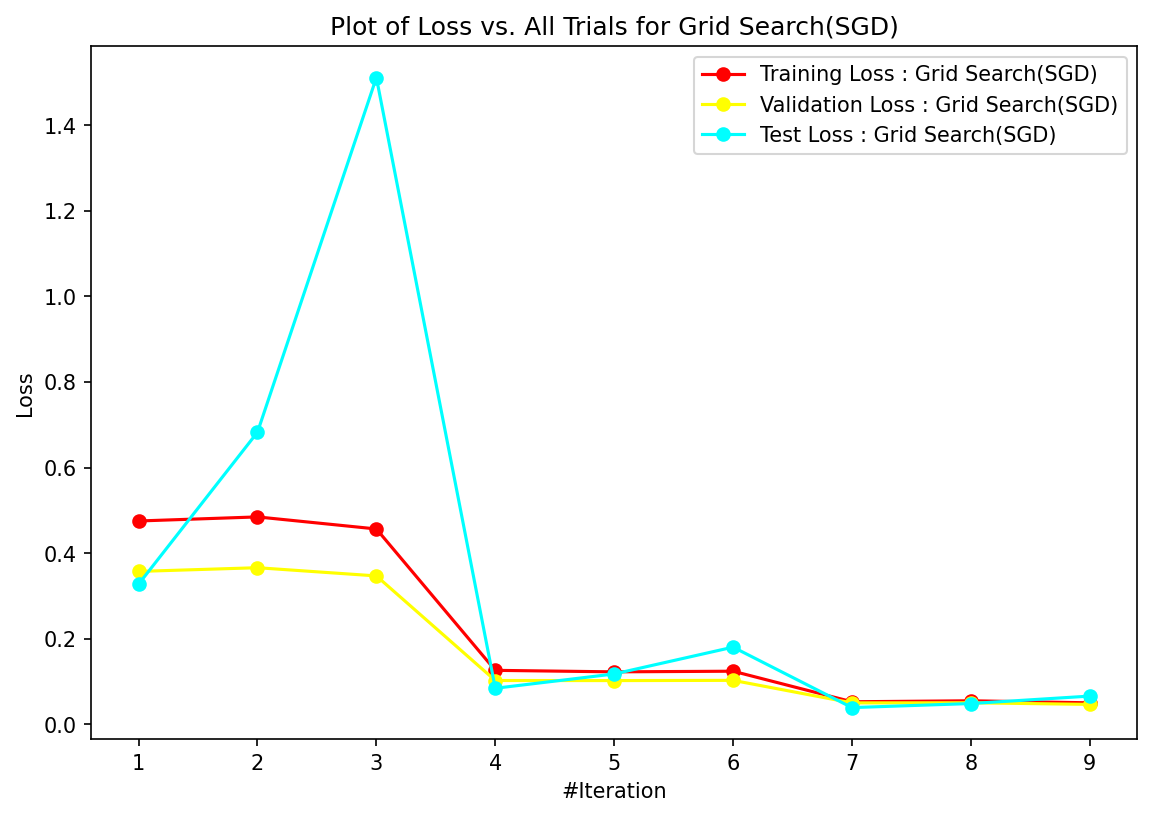

In [15]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), trainingLoss_data, label="Training Loss : Grid Search(SGD)", marker='o', color="Red")
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), validationLoss_data, label="Validation Loss : Grid Search(SGD)", marker='o', color="Yellow")
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), testLoss_data, label="Test Loss : Grid Search(SGD)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Loss")
plot.title('Plot of Loss vs. All Trials for Grid Search(SGD)')
plot.legend()
plot.show()

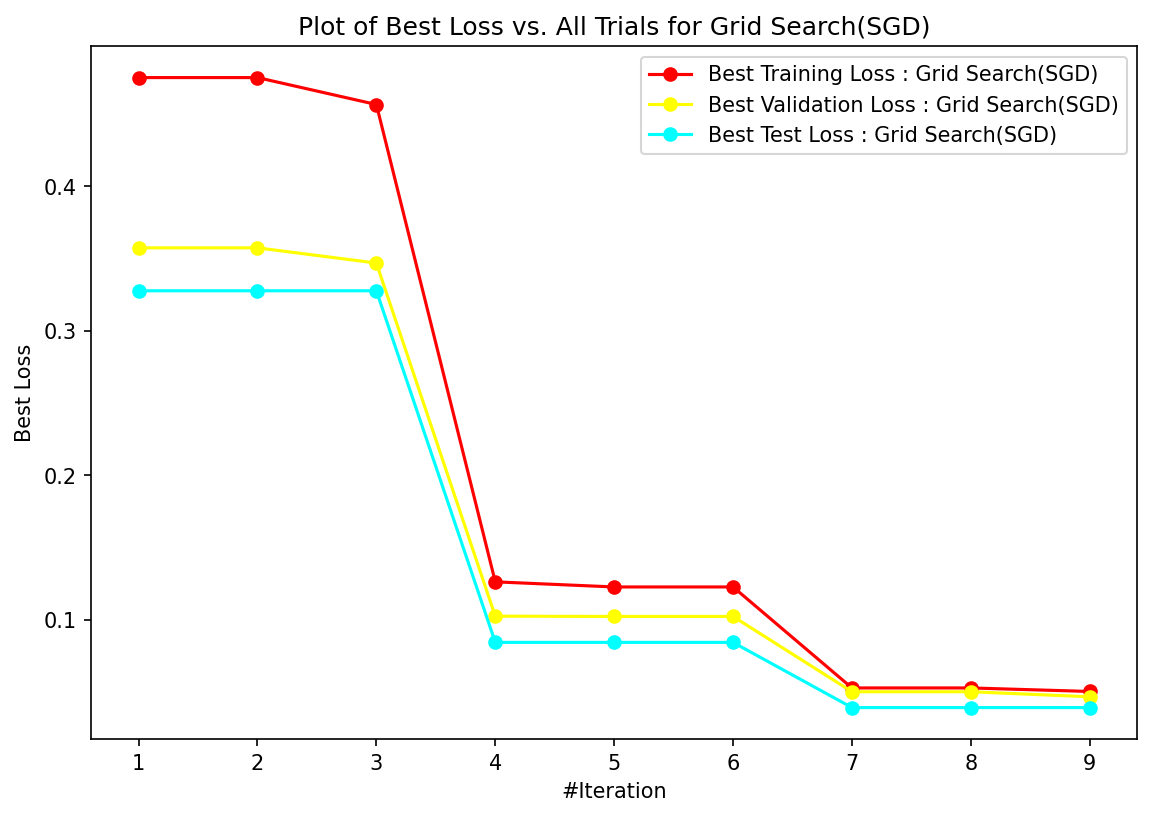

In [16]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), bestTrainingLoss_data, label="Best Training Loss : Grid Search(SGD)", marker='o', color="Red")
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), bestValidationLoss_data, label="Best Validation Loss : Grid Search(SGD)", marker='o', color="Yellow")
plot.plot(range(1, len(gridSearch_SGD_param_values) + 1), bestTestLoss_data, label="Best Test Loss : Grid Search(SGD)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Best Loss")
plot.title('Plot of Best Loss vs. All Trials for Grid Search(SGD)')
plot.legend()
plot.show()

In [18]:
bestTest_GS_SGD_DF = pd.DataFrame(bestTestLoss_data, columns=['BestTestLoss_GS_SGD'])
bestTest_GS_SGD_DF.to_csv('GridSearch_SGD_BestTestLoss.csv', index=False)